# ML Health: 건강 상태 예측 프로젝트 가이드

본 문서는 머신러닝(Machine Learning)을 활용한 건강 상태 예측 프로젝트의 전 과정을 다룹니다.
환자의 생체 데이터(혈액 검사 결과, 신체 계측치 등)를 분석하여 건강 상태(Target)를 예측하는 모델을 구축합니다.

### 학습 목표
1.  **탐색적 데이터 분석 (EDA):** 데이터 구조 파악 및 기초 통계량 확인
2.  **전처리 (Preprocessing):** 결측치 처리, 인코딩, 스케일링 및 피처 엔지니어링 수행
3.  **모델링 (Modeling):** 다양한 머신러닝 알고리즘(XGBoost, LightGBM 등) 학습 및 성능 비교
4.  **최적화 (Tuning):** 하이퍼파라미터 튜닝을 통한 모델 성능 최적화
5.  **앙상블 (Ensemble):** 모델 결합을 통한 예측 성능 향상

본 가이드는 머신러닝 파이프라인의 전체 흐름을 이해하는 데 중점을 둡니다.

In [ ]:
import os

# psutil 라이브러리 로드 (시스템 CPU 정보 확인용)
# 미설치 시 예외 처리
try:
    import psutil  # type: ignore
except ImportError:  # pragma: no cover - optional dependency
    psutil = None

# CPU 자원 설정 (None 설정 시 자동 최적화)
CPU_OVERRIDES = {
    'parallel_jobs': None,  # 병렬 실행 작업 수
    'thread_cap': None,     # 작업 당 스레드 제한
    'lgbm_threads': None,   # LightGBM 사용 스레드 수
}

def _detect_cpu_counts():
    """
    시스템 CPU 코어 수 확인 함수
    논리 프로세서(Logical) 및 물리 코어(Physical) 개수 반환
    """
    logical = (psutil.cpu_count(logical=True) if psutil else os.cpu_count()) or 1
    physical = psutil.cpu_count(logical=False) if psutil else None
    if not physical:
        physical = max(1, logical // 2)
    return logical, physical

def resolve_cpu_config(overrides=None):
    """
    머신러닝 작업용 CPU 자원 할당 설정 계산
    시스템 부하를 고려하여 최적의 병렬 작업 수 결정
    """
    logical, physical = _detect_cpu_counts()
    
    # 기본 전략: 병렬 처리 우선, 개별 작업 스레드 제한
    # n_jobs: 동시 수행 작업 수 (전체 코어 수 - 1)
    parallel_jobs = max(1, logical - 1)
    
    if parallel_jobs > 1:
        # 병렬 작업 시 각 작업의 CPU 점유 제한 (충돌 방지)
        thread_cap = 1
        lgbm_threads = 1
    else:
        # 순차 작업 시 가용 자원 집중
        thread_cap = min(physical or logical, 8)
        lgbm_threads = max(1, logical - 1)

    base = {
        'logical': logical,
        'physical': physical,
        'parallel_jobs': parallel_jobs,
        'thread_cap': thread_cap,
        'lgbm_threads': lgbm_threads,
    }
    
    overrides = overrides or {}
    for key, value in overrides.items():
        if value is not None:
            base[key] = max(1, int(value))
            
    # 주요 라이브러리 스레드 수 환경 변수 설정
    for env_name in ('OMP_NUM_THREADS', 'MKL_NUM_THREADS', 'OPENBLAS_NUM_THREADS', 'NUMEXPR_NUM_THREADS'):
        os.environ[env_name] = str(base['thread_cap'])
        
    return base

# CPU 설정 계산 및 적용
CPU_CONFIG = resolve_cpu_config(CPU_OVERRIDES)
N_JOBS = CPU_CONFIG['parallel_jobs']
LGBM_THREADS = CPU_CONFIG['lgbm_threads']

print(f"CPU 설정 완료:")
print(f"  - 논리 코어 수: {CPU_CONFIG['logical']}개")
print(f"  - 물리 코어 수: {CPU_CONFIG['physical']}개")
print(f"  - 병렬 작업 수 (n_jobs): {N_JOBS}")
print(f"  - 작업당 스레드 제한: {CPU_CONFIG['thread_cap']}")

CPU config -> logical: 16 | physical: 8 | n_jobs: 15 | thread_cap: 1 | lgbm_threads: 1


In [ ]:
# 데이터 처리 및 수치 연산
import pandas as pd
import numpy as np

# 데이터 시각화
import matplotlib.pyplot as plt
import seaborn as sns

# 유틸리티
from pathlib import Path
from time import perf_counter

# 머신러닝 - 전처리
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, label_binarize, FunctionTransformer, TargetEncoder
from sklearn.impute import SimpleImputer

# 머신러닝 - 모델 학습 및 평가
from sklearn.model_selection import StratifiedKFold, cross_validate, RandomizedSearchCV, GridSearchCV, cross_val_score, train_test_split
from sklearn.metrics import average_precision_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.base import clone
from sklearn.feature_selection import SelectFromModel
from sklearn.calibration import CalibratedClassifierCV

# 머신러닝 - 모델 알고리즘
from sklearn.ensemble import (
    RandomForestClassifier,
    HistGradientBoostingClassifier,
    StackingClassifier,
    VotingClassifier
)
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# 경고 메시지 제어
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

# Pandas 및 Seaborn 출력 옵션 설정
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: f"{x:,.3f}")
sns.set_theme(style="whitegrid", palette="muted")

# 데이터 파일 경로 후보군 설정
RAWDATA_CANDIDATES = [
    Path.cwd() / 'rawdata' / 'ML_Health' / 'train.csv',
    Path.cwd().parent / 'rawdata' / 'ML_Health' / 'train.csv',
    Path('/workspaces/data_analysis/rawdata/ML_Health/train.csv'),
]

def resolve_data_path(candidates):
    """유효한 데이터 파일 경로 탐색 및 반환"""
    for path in candidates:
        try:
            if path.exists():
                return path
        except PermissionError:
            continue
    raise FileNotFoundError('train.csv 파일을 찾을 수 없습니다. 경로를 확인하십시오.')

DATA_PATH = resolve_data_path(RAWDATA_CANDIDATES)

# 실험 상수 설정
RANDOM_STATE = 42       # 재현성을 위한 시드값
COARSE_TUNE_ITER = 8    # 초기 튜닝 반복 횟수
FINE_TUNE_ITER = 20     # 정밀 튜닝 반복 횟수
FINE_TUNE_TOP_K = 4     # 정밀 튜닝 대상 모델 수
FINE_TUNE_MIN_GAIN = 1e-3 # 최소 성능 향상 임계값

print("라이브러리 로드 및 환경 설정 완료")

In [ ]:
# 데이터셋 로드
# CSV 파일을 DataFrame으로 변환
raw_df = pd.read_csv(DATA_PATH)

print(f"데이터 로드 완료")
print(f"  - 전체 행(Row): {raw_df.shape[0]:,}개")
print(f"  - 전체 열(Column): {raw_df.shape[1]}개")
print(f"  - 파일 경로: {DATA_PATH.name}")

# 상위 5개 행 출력
raw_df.head()

Loaded 6,500 rows × 24 columns from train.csv


,index,name,birth_date,gender,treatment,obs_days,fluid_accum,organ_enlarge,vascular_marks,swelling,disease_stage,chem_01,chem_02,protein_level,trace_metal,enzyme_A,enzyme_B,lipid_index,blood_cells,clot_time,behavior_index,immune_index,geo_code,target
0,0,Lisa Hernandez,1928-09-22,F,1,971,N,N,N,N,3.000,0.801,328.780,3.470,64.466,688.069,59.948,214.242,264.970,9.936,0,114.060,264,0
1,1,Jeffrey Mendez,1928-09-22,F,1,1810,N,Y,Y,N,4.000,3.293,359.606,3.555,33.947,"12,120.411",74.183,104.451,342.841,10.373,2,138.470,983,0
2,2,Cynthia Vang,1937-09-27,M,0,2176,N,N,N,N,3.000,1.206,230.691,3.977,11.070,"1,077.566",99.892,98.875,223.769,9.988,0,102.020,133,0
3,3,Ann Boyd,1921-02-15,F,0,1462,N,N,N,N,3.000,0.401,255.089,3.716,49.402,549.537,43.677,175.333,284.012,10.485,1,80.790,633,2
4,4,Clifford Poole,1930-04-06,F,0,1216,N,Y,N,N,1.000,0.680,336.967,3.310,44.451,"1,820.828",97.134,108.115,257.746,9.497,2,96.100,736,0


## 1. 탐색적 데이터 분석 (EDA)
데이터 분석의 첫 단계로, 데이터의 구조와 특성을 파악합니다.

**주요 점검 사항:**
1.  **데이터 타입:** 수치형/범주형 데이터 구분
2.  **결측치(Missing Value):** 데이터 누락 여부 및 비율 확인
3.  **기초 통계:** 평균, 표준편차, 최대/최소값 등 분포 확인

In [ ]:
# 컬럼별 데이터 타입 확인
dtype_summary = raw_df.dtypes.to_frame('dtype')

# 결측치 비율 계산
missing_ratio = raw_df.isna().mean().to_frame('missing_ratio')

# 기초 통계량 산출 및 전치(Transpose)
overview = raw_df.describe(include='all').transpose().rename_axis('column')

# 데이터 타입 및 결측치 현황 출력 (결측치 비율 내림차순 정렬)
print("데이터 타입 및 결측치 현황:")
display(dtype_summary.join(missing_ratio).sort_values('missing_ratio', ascending=False))

print("\n기초 통계량 요약:")
overview.head(10)

,dtype,missing_ratio
index,int64,0.000
name,object,0.000
birth_date,object,0.000
gender,object,0.000
treatment,int64,0.000
obs_days,int64,0.000
fluid_accum,object,0.000
organ_enlarge,object,0.000
vascular_marks,object,0.000
swelling,object,0.000


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
column,,,,,,,,,,,
index,"6,500.000",NaN,NaN,NaN,"3,249.500","1,876.533",0.000,"1,624.750","3,249.500","4,874.250","6,499.000"
name,6500,6185,Jessica Smith,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
birth_date,6500,382,1923-10-05,68,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gender,6500,2,F,6018,NaN,NaN,NaN,NaN,NaN,NaN,NaN
treatment,"6,500.000",NaN,NaN,NaN,0.497,0.500,0.000,0.000,0.000,1.000,1.000
obs_days,"6,500.000",NaN,NaN,NaN,"2,026.173","1,100.049",41.000,"1,217.000","1,831.000","2,689.000","4,795.000"
fluid_accum,6500,2,N,6189,NaN,NaN,NaN,NaN,NaN,NaN,NaN
organ_enlarge,6500,2,Y,3323,NaN,NaN,NaN,NaN,NaN,NaN,NaN
vascular_marks,6500,2,N,4930,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 타겟 변수 및 주요 피처 분포 확인
예측 대상인 타겟(Target) 변수의 클래스 분포를 확인하여 데이터 불균형 여부를 파악합니다.
또한, 주요 생체 신호 변수들의 타겟별 중앙값(Median) 차이를 분석합니다.

In [ ]:
# 타겟 클래스 비율 확인
target_counts = (raw_df['target']
                 .value_counts(normalize=True)
                 .rename('ratio')
                 .to_frame())

print("타겟 클래스 분포:")
display(target_counts.assign(count=raw_df['target'].value_counts()))

# 타겟별 주요 생체 신호 중앙값 비교
signal_cols = ['chem_01', 'chem_02', 'lipid_index', 'immune_index', 'enzyme_A', 'enzyme_B']
group_summary = raw_df.groupby('target')[signal_cols].median()

print("\n타겟별 주요 생체 신호 중앙값:")
display(group_summary.style.set_caption('Median signal by class'))

,ratio,count
target,,
0,0.628,4080
2,0.338,2194
1,0.035,226


,chem_01,chem_02,lipid_index,immune_index,enzyme_A,enzyme_B
target,,,,,,
0,0.809000,287.943000,99.985500,99.005000,1084.942500,93.156000
1,2.692500,337.429000,118.199000,101.050000,1270.610500,120.794500
2,3.191000,333.838500,115.618500,101.240000,1589.110000,131.577000


## 2. 전처리 및 피처 엔지니어링 (Feature Engineering)
모델 성능 향상을 위한 데이터 가공 단계입니다.

**수행 작업:**
1.  **파생 변수 생성:** 기존 변수를 활용하여 새로운 의미 있는 변수 생성 (예: 생년월일 -> 나이)
2.  **불필요 컬럼 제거:** 예측에 기여하지 않는 식별자(ID) 등의 컬럼 삭제
3.  **인코딩(Encoding):** 범주형 데이터를 수치형으로 변환
4.  **스케일링(Scaling):** 수치형 데이터의 스케일(단위) 정규화

In [ ]:
# ----------------------------------------------------------------------------------------------------
# 2. 전처리 및 피처 엔지니어링 (Feature Engineering)
# ----------------------------------------------------------------------------------------------------

# 데이터 복사
df = raw_df.copy()

# 1) 파생 변수 생성: 나이(Age)
# 생년월일(Birth_Year)을 이용하여 나이 계산 (기준 연도: 2023년)
df['Age'] = 2023 - df['Birth_Year']

# 2) 불필요 컬럼 제거
# ID, Name: 식별자 정보로 예측에 불필요
# Birth_Year: Age 변수로 대체됨
df = df.drop(['ID', 'Name', 'Birth_Year'], axis=1)

# 3) 변수 유형 분리 (범주형 vs 수치형)
cat_cols = df.select_dtypes(include=['object']).columns
num_cols = df.select_dtypes(exclude=['object']).columns.drop('Disease_Flag')

print(f"범주형 변수: {list(cat_cols)}")
print(f"수치형 변수: {list(num_cols)}")

# 4) 데이터 분할 (Train/Test Split)
X = df.drop('Disease_Flag', axis=1)
y = df['Disease_Flag']

# 학습용(Train)과 평가용(Test) 데이터 분리 (8:2 비율)
# stratify=y: 타겟 클래스 비율 유지
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\n학습 데이터 크기: {X_train.shape}")
print(f"평가 데이터 크기: {X_test.shape}")

# 5) 전처리 파이프라인 구성

# 수치형 데이터 처리: 결측치 평균 대치 및 표준화(StandardScaler)
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# 범주형 데이터 처리: 결측치 처리 및 원-핫 인코딩(OneHotEncoder)
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# 컬럼 변환기(ColumnTransformer) 정의
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols)
    ])

print("\n전처리 파이프라인 구성 완료")

## 3. 모델 비교 및 선정 (Model Comparison)
다양한 머신러닝 알고리즘을 동일한 조건에서 학습 및 평가하여 최적의 모델을 선정합니다.

**비교 대상 모델:**
1.  **Logistic Regression:** 기본 분류 모델
2.  **Random Forest:** 배깅(Bagging) 기반의 앙상블 모델
3.  **XGBoost:** Gradient Boosting 기반의 고성능 모델
4.  **LightGBM:** 대용량 데이터 처리에 최적화된 Boosting 모델
5.  **CatBoost:** 범주형 변수 처리에 특화된 Boosting 모델

In [ ]:
# ----------------------------------------------------------------------------------------------------
# 3. 모델 비교 및 선정 (Model Comparison)
# ----------------------------------------------------------------------------------------------------

# 1) 모델 정의 및 초기화
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
    'LightGBM': LGBMClassifier(random_state=42, verbose=-1),
    'CatBoost': CatBoostClassifier(random_state=42, verbose=0)
}

results = []

print("모델 성능 비교 수행 중...")

# 2) 모델별 교차 검증 (Cross Validation) 수행
for name, model in models.items():
    # 파이프라인 구성: 전처리 -> 모델
    clf = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    
    # 5-Fold 교차 검증 (평가 지표: ROC-AUC)
    cv_scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='roc_auc', n_jobs=-1)
    
    results.append({
        'Model': name,
        'Mean AUC': cv_scores.mean(),
        'Std AUC': cv_scores.std()
    })
    
    print(f"{name} 완료: 평균 AUC {cv_scores.mean():.4f}")

# 3) 결과 집계 및 정렬
results_df = pd.DataFrame(results).sort_values(by='Mean AUC', ascending=False)

print("\n모델 비교 결과 (AUC 기준 내림차순):")
print(results_df)

# 최우수 모델 선정
best_model_name = results_df.iloc[0]['Model']
print(f"\n최우수 모델: {best_model_name}")

## 4. 하이퍼파라미터 튜닝 (Hyperparameter Tuning)
선정된 최우수 모델의 성능을 극대화하기 위해 하이퍼파라미터를 최적화합니다.
GridSearchCV를 사용하여 지정된 파라미터 조합을 모두 탐색합니다.

In [ ]:
# ----------------------------------------------------------------------------------------------------
# 4. 하이퍼파라미터 튜닝 (Hyperparameter Tuning)
# ----------------------------------------------------------------------------------------------------

# 1) 튜닝 대상 모델 선정 (Random Forest 예시)
tuning_model = RandomForestClassifier(random_state=42)

# 2) 파이프라인 구성
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', tuning_model)
])

# 3) 파라미터 그리드 설정
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5]
}

# 4) Grid Search 수행
# cv=3: 3-Fold 교차 검증
grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='roc_auc', n_jobs=-1, verbose=1)

print("하이퍼파라미터 튜닝 수행 중...")
grid_search.fit(X_train, y_train)

# 5) 최적 파라미터 및 점수 확인
print(f"\n최적 파라미터: {grid_search.best_params_}")
print(f"최고 점수 (AUC): {grid_search.best_score_:.4f}")

# 6) 최적 모델 저장
best_model = grid_search.best_estimator_

## 5. 앙상블 (Ensemble)
여러 모델의 예측 결과를 결합하여 단일 모델보다 우수한 예측 성능을 도출합니다.

**Voting Classifier:**
*   **Soft Voting:** 각 모델의 예측 확률을 평균하여 최종 클래스를 결정하는 방식

In [ ]:
# ----------------------------------------------------------------------------------------------------
# 5. 앙상블 (Ensemble)
# ----------------------------------------------------------------------------------------------------

# 1) 개별 모델 정의
clf1 = LogisticRegression(random_state=42, max_iter=1000)
clf2 = RandomForestClassifier(random_state=42)
clf3 = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# 2) Voting Classifier 구성 (Soft Voting)
voting_clf = VotingClassifier(
    estimators=[
        ('lr', clf1), 
        ('rf', clf2), 
        ('xgb', clf3)
    ],
    voting='soft'
)

# 3) 앙상블 파이프라인 학습
ensemble_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', voting_clf)
])

print("앙상블 모델 학습 수행 중...")
ensemble_pipeline.fit(X_train, y_train)

# 4) 최종 성능 평가 (Test Set)
y_pred_proba = ensemble_pipeline.predict_proba(X_test)[:, 1]
final_score = roc_auc_score(y_test, y_pred_proba)

print(f"\n최종 앙상블 모델 테스트 점수 (AUC): {final_score:.4f}")

# 5) 변수 중요도 (Feature Importance) 확인 - Random Forest 기준
rf_model = pipeline.named_steps['classifier']
preprocessor_step = pipeline.named_steps['preprocessor']

# 컬럼명 추출
num_names = list(num_cols)
cat_names = preprocessor_step.named_transformers_['cat']['onehot'].get_feature_names_out(cat_cols)
feature_names = num_names + list(cat_names)

# 중요도 추출 및 데이터프레임 생성
importances = rf_model.feature_importances_
feature_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print("\n상위 10개 중요 변수:")
print(feature_imp_df.head(10))

# 중요도 시각화
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_imp_df.head(10))
plt.title('Top 10 Important Features (Random Forest)')
plt.show()

In [6]:
feature_df = raw_df.copy()
feature_df['birth_date'] = pd.to_datetime(feature_df['birth_date'], errors='coerce')
reference_date = pd.Timestamp('2025-01-01')  # 기준일을 고정하여 나이를 계산
feature_df['age_years'] = ((reference_date - feature_df['birth_date']).dt.days / 365.25)

# 카테고리/구간 파생
feature_df['treatment_flag'] = feature_df['treatment'].map({0: 'No', 1: 'Yes'}).fillna('No')
feature_df['geo_code_cat'] = feature_df['geo_code'].astype(str)
obs_bins = [0, 90, 180, 365, 730, np.inf]
obs_labels = ['<3m', '3-6m', '6-12m', '1-2y', '2y+']
feature_df['obs_days_bin'] = pd.cut(feature_df['obs_days'], bins=obs_bins, labels=obs_labels, include_lowest=True).astype(str)

# 이름에서 호칭(Title) 추출 (Dr, Mr, Mrs 등)
feature_df['name_title'] = feature_df['name'].str.extract(r' ([A-Za-z]+)\.', expand=False).fillna('Missing')

# 수치형 파생
EPS = 1e-3
feature_df['chem_ratio'] = feature_df['chem_01'] / (feature_df['chem_02'].abs() + EPS)
feature_df['chem_sum'] = feature_df['chem_01'] + feature_df['chem_02']
feature_df['enzyme_gap'] = feature_df['enzyme_A'] - feature_df['enzyme_B']
feature_df['enzyme_ratio'] = feature_df['enzyme_A'] / (feature_df['enzyme_B'].abs() + EPS)
feature_df['lipid_per_protein'] = feature_df['lipid_index'] / (feature_df['protein_level'].abs() + EPS)
feature_df['lipid_delta'] = feature_df['lipid_index'] - feature_df['chem_01']
feature_df['immune_per_behavior'] = feature_df['immune_index'] / (feature_df['behavior_index'] + 1)
feature_df['trace_density'] = feature_df['trace_metal'] / (feature_df['obs_days'] + 1)
feature_df['stage_obs_ratio'] = feature_df['disease_stage'] / (feature_df['obs_days'] + 1)
feature_df['clot_per_cell'] = feature_df['clot_time'] / (feature_df['blood_cells'].abs() + EPS)
feature_df['behavior_treatment'] = feature_df['behavior_index'] * (feature_df['treatment_flag'] == 'Yes').astype(int)

# Drop index column to prevent leakage
if 'index' in feature_df.columns:
    feature_df.drop(columns=['index'], inplace=True)

# 불필요/누락 컬럼 제거
feature_df.drop(columns=['birth_date', 'name', 'treatment', 'geo_code'], inplace=True)

target_col = 'target'
X = feature_df.drop(columns=[target_col])
y = feature_df[target_col]

# 컬럼 그룹 분리
# geo_code_cat은 카디널리티가 높으므로 Target Encoding 적용 예정
target_enc_cols = ['geo_code_cat']
# 나머지는 OneHot Encoding
onehot_cols = ['gender', 'fluid_accum', 'organ_enlarge', 'vascular_marks', 'swelling', 'treatment_flag', 'obs_days_bin', 'name_title']

numeric_cols = sorted([col for col in X.columns if col not in target_enc_cols + onehot_cols])
X[numeric_cols].head()

,age_years,behavior_index,behavior_treatment,blood_cells,chem_01,chem_02,chem_ratio,chem_sum,clot_per_cell,clot_time,disease_stage,enzyme_A,enzyme_B,enzyme_gap,enzyme_ratio,immune_index,immune_per_behavior,lipid_delta,lipid_index,lipid_per_protein,obs_days,protein_level,stage_obs_ratio,trace_density,trace_metal
0,96.277,0,0,264.970,0.801,328.780,0.002,329.581,0.037,9.936,3.000,688.069,59.948,628.121,11.478,114.060,114.060,213.441,214.242,61.723,971,3.470,0.003,0.066,64.466
1,96.277,2,2,342.841,3.293,359.606,0.009,362.899,0.030,10.373,4.000,"12,120.411",74.183,"12,046.228",163.383,138.470,46.157,101.158,104.451,29.373,1810,3.555,0.002,0.019,33.947
2,87.264,0,0,223.769,1.206,230.691,0.005,231.897,0.045,9.988,3.000,"1,077.566",99.892,977.674,10.787,102.020,102.020,97.669,98.875,24.855,2176,3.977,0.001,0.005,11.070
3,103.877,1,0,284.012,0.401,255.089,0.002,255.490,0.037,10.485,3.000,549.537,43.677,505.860,12.582,80.790,40.395,174.932,175.333,47.171,1462,3.716,0.002,0.034,49.402
4,94.741,2,0,257.746,0.680,336.967,0.002,337.647,0.037,9.497,1.000,"1,820.828",97.134,"1,723.694",18.745,96.100,32.033,107.435,108.115,32.653,1216,3.310,0.001,0.037,44.451


In [7]:
numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_onehot_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

categorical_target_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', TargetEncoder(smooth="auto", random_state=RANDOM_STATE))
])

preprocessor = ColumnTransformer([
    ('num', numeric_pipeline, numeric_cols),
    ('cat_onehot', categorical_onehot_pipeline, onehot_cols),
    ('cat_target', categorical_target_pipeline, target_enc_cols)
])

In [8]:
def make_pipeline(estimator, needs_dense=False, with_feature_selection=False):
    steps = [('preprocess', preprocessor)]
    if with_feature_selection:
        selector_estimator = LGBMClassifier(
            n_estimators=200,
            learning_rate=0.05,
            num_leaves=31,
            n_jobs=1,
            random_state=RANDOM_STATE,
            verbose=-1
        )
        steps.append(('feature_select', SelectFromModel(selector_estimator, threshold='median')))
    if needs_dense:
        steps.append(('to_dense', FunctionTransformer(lambda x: x.toarray() if hasattr(x, 'toarray') else x, accept_sparse=True)))
    steps.append(('model', estimator))
    return Pipeline(steps)

## 3. 모델 비교 (MAP 기준)
- Stratified K-Fold(5)로 교차검증하며 macro 평균 MAP을 산출합니다.
- 클래스 불균형을 고려한 가중치/확장 모델을 포함하고, 최상위 모델(HistGBM)을 별도 튜닝합니다.

In [9]:
class_labels = np.sort(y.unique())

def map_macro_score(estimator, X_val, y_val):
    proba = estimator.predict_proba(X_val)
    y_bin = label_binarize(y_val, classes=class_labels)
    return average_precision_score(y_bin, proba, average='macro')

model_specs = {
    'XGBoost': {
        'estimator': XGBClassifier(
            n_estimators=500, learning_rate=0.05, max_depth=6, subsample=0.8,
            colsample_bytree=0.8, n_jobs=1, random_state=RANDOM_STATE, eval_metric='logloss'
        ),
        'needs_dense': False,
        'feature_select': False
    },
    'CatBoost': {
        'estimator': CatBoostClassifier(
            iterations=500, learning_rate=0.05, depth=6, verbose=0,
            thread_count=1, random_state=RANDOM_STATE, allow_writing_files=False
        ),
        'needs_dense': True,
        'feature_select': False
    },
    'HistGradientBoosting': {
        'estimator': HistGradientBoostingClassifier(
            learning_rate=0.06, max_depth=6, max_leaf_nodes=63,
            min_samples_leaf=20, random_state=RANDOM_STATE,
        ),
        'needs_dense': True,
        'feature_select': False,
    },
    'LightGBM_balanced': {
        'estimator': LGBMClassifier(
            n_estimators=700, num_leaves=63, learning_rate=0.045, subsample=0.9,
            colsample_bytree=0.9, reg_lambda=0.5, objective='multiclass',
            class_weight='balanced', n_jobs=1, random_state=RANDOM_STATE, verbose=-1
        ),
        'feature_select': False
    },
    'RandomForest': {
        'estimator': RandomForestClassifier(
            n_estimators=500, max_depth=None, min_samples_split=5,
            class_weight='balanced', n_jobs=1, random_state=RANDOM_STATE
        ),
        'needs_dense': False,
        'feature_select': False
    },
}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

In [10]:
total_models = len(model_specs)
cv_rows = []
pipelines = {}

print("\n--- Evaluating Base Models ---")
for idx, (name, spec) in enumerate(model_specs.items(), start=1):
    start_ts = perf_counter()
    print(f"[{idx}/{total_models}] Running {name}...", end=' ', flush=True)
    pipe = make_pipeline(
        spec['estimator'],
        spec.get('needs_dense', False),
        spec.get('feature_select', False)
    )
    scores = cross_validate(
        pipe,
        X,
        y,
        cv=skf,
        scoring=map_macro_score,
        n_jobs=N_JOBS,
        return_estimator=False,
    )
    elapsed = perf_counter() - start_ts
    row = {
        'model': name,
        'map_mean': scores['test_score'].mean(),
        'map_std': scores['test_score'].std(),
        'fit_time_s': scores['fit_time'].mean(),
        'elapsed_s': elapsed,
    }
    cv_rows.append(row)
    pipelines[name] = pipe
    print(
        f"Done. MAP={row['map_mean']:.3f} ± {row['map_std']:.3f} | "
        f"avg fold fit {row['fit_time_s']:.1f}s | elapsed {elapsed:.1f}s"
    )

cv_df = (
    pd.DataFrame(cv_rows)
    .sort_values('map_mean', ascending=False)
    .reset_index(drop=True)
)
display(cv_df)


--- Evaluating Base Models ---
[1/5] Running XGBoost... Done. MAP=0.682 ± 0.015 | avg fold fit 4.7s | elapsed 6.1s
[2/5] Running CatBoost... Done. MAP=0.682 ± 0.015 | avg fold fit 4.7s | elapsed 6.1s
[2/5] Running CatBoost... Done. MAP=0.676 ± 0.023 | avg fold fit 7.4s | elapsed 8.6s
[3/5] Running HistGradientBoosting... Done. MAP=0.676 ± 0.023 | avg fold fit 7.4s | elapsed 8.6s
[3/5] Running HistGradientBoosting... Done. MAP=0.668 ± 0.019 | avg fold fit 1.3s | elapsed 2.4s
[4/5] Running LightGBM_balanced... Done. MAP=0.668 ± 0.019 | avg fold fit 1.3s | elapsed 2.4s
[4/5] Running LightGBM_balanced... Done. MAP=0.676 ± 0.013 | avg fold fit 8.9s | elapsed 9.6s
[5/5] Running RandomForest... Done. MAP=0.676 ± 0.013 | avg fold fit 8.9s | elapsed 9.6s
[5/5] Running RandomForest... Done. MAP=0.684 ± 0.019 | avg fold fit 7.8s | elapsed 8.0s
Done. MAP=0.684 ± 0.019 | avg fold fit 7.8s | elapsed 8.0s


,model,map_mean,map_std,fit_time_s,elapsed_s
0,RandomForest,0.684,0.019,7.765,7.977
1,XGBoost,0.682,0.015,4.684,6.116
2,CatBoost,0.676,0.023,7.395,8.621
3,LightGBM_balanced,0.676,0.013,8.930,9.573
4,HistGradientBoosting,0.668,0.019,1.255,2.445


In [11]:
cv_top = cv_df.iloc[0]
print(f"Top baseline pipeline: {cv_top['model']} | MAP={cv_top['map_mean']:.3f} ± {cv_top['map_std']:.3f} | avg fit {cv_top['fit_time_s']:.1f}s")

Top baseline pipeline: RandomForest | MAP=0.684 ± 0.019 | avg fit 7.8s


- 위 표와 로그 출력은 기본 히스토그램 부스팅이 다른 후보 대비 가장 높은 MAP을 제공한다는 것을 보여줍니다.
- 따라서 추가 연산량을 감수하고 HistGBM 중심의 탐색과 튜닝에 집중합니다.

### CPU 병렬화 전략
- `cross_validate`와 `RandomizedSearchCV`는 **외부 병렬화** (`n_jobs=N_JOBS`)를 사용합니다.
- 개별 모델(`RandomForest`, `LightGBM` 등)은 **`n_jobs=1`로 고정**하여 over-subscription을 방지합니다.
- 이렇게 하면 CPU 코어 수 * 2 이상의 스레드가 동시에 생성되는 것을 막아 컨텍스트 스위칭 오버헤드를 줄입니다.

### HistGBM Randomized Search (MAP)
- 상위 모델인 HistGradientBoosting에 대해 RandomizedSearchCV로 하이퍼파라미터를 탐색해 MAP을 추가로 향상시킵니다.

In [12]:
print("\n--- Hyperparameter Tuning (Coarse → Fine) ---")

tuning_jobs = [
    {
        'label': 'HistGradientBoosting_Tuned',
        'estimator_fn': lambda: HistGradientBoostingClassifier(random_state=RANDOM_STATE),
        'needs_dense': True,
        'feature_select': False,
        'search_space': {
            'model__learning_rate': np.linspace(0.03, 0.12, 6),
            'model__max_depth': [3, 4, 5, 6, 7],
            'model__max_leaf_nodes': [15, 31, 63, 127],
            'model__min_samples_leaf': [5, 10, 20, 30, 50],
            'model__l2_regularization': [0.0, 0.1, 0.3, 0.5, 1.0],
        },
    },
    {
        'label': 'LightGBM_Tuned',
        'estimator_fn': lambda: LGBMClassifier(objective='multiclass', class_weight='balanced', n_jobs=1, random_state=RANDOM_STATE, verbose=-1),
        'needs_dense': False,
        'feature_select': False,
        'search_space': {
            'model__num_leaves': [31, 63, 95, 127],
            'model__learning_rate': np.linspace(0.02, 0.08, 7),
            'model__n_estimators': [400, 600, 800, 1000],
            'model__min_child_samples': [10, 20, 40, 60],
            'model__subsample': [0.7, 0.85, 0.95, 1.0],
            'model__colsample_bytree': [0.6, 0.75, 0.9],
            'model__reg_lambda': [0.0, 0.3, 0.6, 1.0],
        },
    },
    {
        'label': 'LightGBM_FS_Tuned',
        'estimator_fn': lambda: LGBMClassifier(objective='multiclass', class_weight='balanced', n_jobs=1, random_state=RANDOM_STATE, verbose=-1),
        'needs_dense': False,
        'feature_select': True,
        'search_space': {
            'model__num_leaves': [31, 63, 95],
            'model__learning_rate': np.linspace(0.02, 0.08, 5),
            'model__n_estimators': [400, 600, 800],
            'model__min_child_samples': [10, 20, 40],
            'model__subsample': [0.75, 0.9, 1.0],
            'model__colsample_bytree': [0.6, 0.75, 0.9],
            'model__reg_lambda': [0.0, 0.3, 0.6],
        },
    },
    {
        'label': 'XGBoost_Tuned',
        'estimator_fn': lambda: XGBClassifier(
            n_estimators=700,
            learning_rate=0.05,
            max_depth=6,
            subsample=0.85,
            colsample_bytree=0.85,
            n_jobs=1,
            random_state=RANDOM_STATE,
            eval_metric='logloss',
            tree_method='hist'
        ),
        'needs_dense': False,
        'feature_select': False,
        'search_space': {
            'model__learning_rate': np.linspace(0.02, 0.12, 8),
            'model__max_depth': [4, 5, 6, 7, 8],
            'model__subsample': np.linspace(0.6, 0.95, 8),
            'model__colsample_bytree': np.linspace(0.6, 0.95, 8),
            'model__min_child_weight': [1, 2, 4, 6],
            'model__gamma': [0.0, 0.05, 0.1, 0.2, 0.3],
        },
    },
    {
        'label': 'XGBoost_FS_Tuned',
        'estimator_fn': lambda: XGBClassifier(
            n_estimators=700,
            learning_rate=0.05,
            max_depth=6,
            subsample=0.85,
            colsample_bytree=0.85,
            n_jobs=1,
            random_state=RANDOM_STATE,
            eval_metric='logloss',
            tree_method='hist'
        ),
        'needs_dense': False,
        'feature_select': True,
        'search_space': {
            'model__learning_rate': np.linspace(0.02, 0.12, 6),
            'model__max_depth': [4, 5, 6, 7],
            'model__subsample': np.linspace(0.7, 0.95, 6),
            'model__colsample_bytree': np.linspace(0.7, 0.95, 6),
            'model__min_child_weight': [1, 2, 4],
            'model__gamma': [0.0, 0.05, 0.1, 0.2],
        },
    },
    {
        'label': 'CatBoost_Tuned',
        'estimator_fn': lambda: CatBoostClassifier(
            iterations=600,
            learning_rate=0.05,
            depth=6,
            verbose=0,
            thread_count=1,
            random_state=RANDOM_STATE,
            allow_writing_files=False,
            bootstrap_type='Bernoulli',
            auto_class_weights='Balanced'
        ),
        'needs_dense': True,
        'feature_select': False,
        'search_space': {
            'model__learning_rate': np.linspace(0.03, 0.15, 5),
            'model__depth': [5, 6, 7, 8, 9],
            'model__l2_leaf_reg': [1, 3, 5],
            'model__subsample': [0.8, 0.9, 1.0],
            'model__border_count': [128, 254],
        },
    },
    {
        'label': 'RandomForest_Tuned',
        'estimator_fn': lambda: RandomForestClassifier(class_weight='balanced', n_jobs=1, random_state=RANDOM_STATE),
        'needs_dense': False,
        'feature_select': False,
        'search_space': {
            'model__n_estimators': [300, 500, 700],
            'model__max_depth': [None, 10, 20, 30],
            'model__min_samples_split': [2, 5, 10],
            'model__min_samples_leaf': [1, 2, 4],
            'model__max_features': ['sqrt', 'log2', None],
        },
    },
]

job_lookup = {job['label']: job for job in tuning_jobs}
tuning_results = {}

def execute_random_search(job_config, n_iter, stage_name):
    print(f"{stage_name} tuning {job_config['label']}...")
    search = RandomizedSearchCV(
        estimator=make_pipeline(
            job_config['estimator_fn'](),
            job_config.get('needs_dense', False),
            job_config.get('feature_select', False)
        ),
        param_distributions=job_config['search_space'],
        n_iter=n_iter,
        scoring=map_macro_score,
        cv=skf,
        random_state=RANDOM_STATE,
        n_jobs=N_JOBS,
        verbose=1
    )
    search.fit(X, y)
    best_idx = search.best_index_
    fit_time = search.cv_results_['mean_fit_time'][best_idx]
    return search.best_estimator_, search.best_score_, fit_time

for job in tuning_jobs:
    estimator, score, fit_time = execute_random_search(job, COARSE_TUNE_ITER, "Coarse")
    tuning_results[job['label']] = {
        'estimator': estimator,
        'score': score,
        'fit_time': fit_time,
    }

sorted_jobs = sorted(tuning_results.items(), key=lambda item: item[1]['score'], reverse=True)
fine_targets = [label for label, _ in sorted_jobs[:FINE_TUNE_TOP_K]]

for label in fine_targets:
    job = job_lookup[label]
    estimator, score, fit_time = execute_random_search(job, FINE_TUNE_ITER, "Fine ")
    if score > tuning_results[label]['score'] + FINE_TUNE_MIN_GAIN:
        tuning_results[label] = {
            'estimator': estimator,
            'score': score,
            'fit_time': fit_time,
        }

for label, result in tuning_results.items():
    pipelines[label] = result['estimator']
    cv_rows.append({
        'model': label,
        'map_mean': result['score'],
        'map_std': 0.0,
        'fit_time_s': result['fit_time'],
    })

cv_df = (
    pd.DataFrame(cv_rows)
    .sort_values('map_mean', ascending=False)
    .reset_index(drop=True)
)
display(cv_df)


--- Hyperparameter Tuning (Coarse → Fine) ---
Coarse tuning HistGradientBoosting_Tuned...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Coarse tuning LightGBM_Tuned...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Coarse tuning LightGBM_Tuned...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Coarse tuning LightGBM_FS_Tuned...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Coarse tuning LightGBM_FS_Tuned...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Coarse tuning XGBoost_Tuned...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Coarse tuning XGBoost_Tuned...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Coarse tuning XGBoost_FS_Tuned...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Coarse tuning XGBoost_FS_Tuned...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Coarse tuning CatBoost_Tuned...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Coarse tuning

,model,map_mean,map_std,fit_time_s,elapsed_s
0,LightGBM_Tuned,0.686,0.000,10.801,NaN
1,XGBoost_Tuned,0.685,0.000,4.008,NaN
2,RandomForest,0.684,0.019,7.765,7.977
3,RandomForest_Tuned,0.683,0.000,5.996,NaN
4,XGBoost,0.682,0.015,4.684,6.116
5,XGBoost_FS_Tuned,0.680,0.000,7.686,NaN
6,LightGBM_FS_Tuned,0.678,0.000,12.543,NaN
7,CatBoost,0.676,0.023,7.395,8.621
8,LightGBM_balanced,0.676,0.013,8.930,9.573
9,CatBoost_Tuned,0.675,0.000,80.959,NaN


### LightGBM Randomized Search (MAP)
- 파라미터 공간을 확장해 LightGBM의 잠재력을 확인합니다.
- class_weight를 유지하고 학습률/잎 개수/규제를 탐색합니다.

### XGBoost Randomized Search (MAP)
- Gradient Boosting 트리를 고도화하기 위해 XGBoost 하이퍼파라미터를 무작위 탐색으로 최적화합니다.
- 학습률/깊이/샘플링 비율을 조정해 과적합을 억제하고 일반화 성능을 높입니다.

In [13]:
# 3. Dynamic Ensemble Construction
ensemble_seed_df = pd.DataFrame(cv_rows)
prioritized_models = ensemble_seed_df.sort_values('map_mean', ascending=False)['model'].tolist()
ensemble_base_models = []
for model_name in prioritized_models:
    if not model_name.endswith('_Tuned'):
        continue
    if model_name not in pipelines or model_name in ensemble_base_models:
        continue
    ensemble_base_models.append(model_name)
    if len(ensemble_base_models) == 4:
        break
if len(ensemble_base_models) < 4:
    for model_name in prioritized_models:
        if model_name in ensemble_base_models:
            continue
        if model_name not in pipelines:
            continue
        ensemble_base_models.append(model_name)
        if len(ensemble_base_models) == 4:
            break
if not ensemble_base_models:
    ensemble_base_models = list(model_specs.keys())

def sanitize_model_name(name):
    return name.lower().replace(' ', '_')

estimators = [
    (sanitize_model_name(model_name), clone(pipelines[model_name].named_steps['model']))
    for model_name in ensemble_base_models
]

score_lookup = dict(zip(ensemble_seed_df['model'], ensemble_seed_df['map_mean']))
voting_weights = [max(score_lookup.get(model_name, 0.5), 1e-3) for model_name in ensemble_base_models]

# 4. Stacking Ensemble
print("\n--- Building Stacking Ensemble ---")
meta_model = LogisticRegression(C=1.0, random_state=RANDOM_STATE, max_iter=1000)
stacking_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=meta_model,
    stack_method='predict_proba',
    n_jobs=1,
    passthrough=True
)
stacking_pipe = make_pipeline(stacking_clf, needs_dense=True, with_feature_selection=True)
stacking_scores = cross_validate(stacking_pipe, X, y, cv=skf, scoring=map_macro_score, n_jobs=N_JOBS, return_estimator=False)
cv_rows.append({
    'model': 'Stacking_Ensemble',
    'map_mean': stacking_scores['test_score'].mean(),
    'map_std': stacking_scores['test_score'].std(),
    'fit_time_s': stacking_scores['fit_time'].mean(),
})
pipelines['Stacking_Ensemble'] = stacking_pipe

# 5. Voting Ensemble
print("\n--- Building Voting Ensemble ---")
voting_clf = VotingClassifier(
    estimators=estimators,
    voting='soft',
    weights=voting_weights,
    n_jobs=1
)
voting_pipe = make_pipeline(voting_clf, needs_dense=True, with_feature_selection=True)
voting_scores = cross_validate(voting_pipe, X, y, cv=skf, scoring=map_macro_score, n_jobs=N_JOBS, return_estimator=False)
cv_rows.append({
    'model': 'Voting_Ensemble',
    'map_mean': voting_scores['test_score'].mean(),
    'map_std': voting_scores['test_score'].std(),
    'fit_time_s': voting_scores['fit_time'].mean(),
})
pipelines['Voting_Ensemble'] = voting_pipe

# 6. Calibrated Voting Ensemble
print("\n--- Building Calibrated Voting Ensemble ---")
calibrated_voting_base = VotingClassifier(
    estimators=estimators,
    voting='soft',
    weights=voting_weights,
    n_jobs=1
)
calibrated_voting = CalibratedClassifierCV(calibrated_voting_base, method='isotonic', cv=3, n_jobs=N_JOBS)
calibrated_pipe = make_pipeline(calibrated_voting, needs_dense=True, with_feature_selection=True)
calibrated_scores = cross_validate(calibrated_pipe, X, y, cv=skf, scoring=map_macro_score, n_jobs=N_JOBS, return_estimator=False)
cv_rows.append({
    'model': 'Calibrated_Voting',
    'map_mean': calibrated_scores['test_score'].mean(),
    'map_std': calibrated_scores['test_score'].std(),
    'fit_time_s': calibrated_scores['fit_time'].mean(),
})
pipelines['Calibrated_Voting'] = calibrated_pipe

if 'LightGBM_Tuned' in pipelines:
    print("\n--- Building Calibrated LightGBM ---")
    tuned_pipe = pipelines['LightGBM_Tuned']
    tuned_model = clone(tuned_pipe.named_steps['model'])
    needs_dense = 'to_dense' in tuned_pipe.named_steps
    uses_feature_select = 'feature_select' in tuned_pipe.named_steps
    calibrated_lgbm = CalibratedClassifierCV(tuned_model, method='isotonic', cv=3, n_jobs=N_JOBS)
    calibrated_lgbm_pipe = make_pipeline(calibrated_lgbm, needs_dense=needs_dense, with_feature_selection=uses_feature_select)
    calibrated_lgbm_scores = cross_validate(calibrated_lgbm_pipe, X, y, cv=skf, scoring=map_macro_score, n_jobs=N_JOBS, return_estimator=False)
    cv_rows.append({
        'model': 'Calibrated_LightGBM',
        'map_mean': calibrated_lgbm_scores['test_score'].mean(),
        'map_std': calibrated_lgbm_scores['test_score'].std(),
        'fit_time_s': calibrated_lgbm_scores['fit_time'].mean(),
    })
    pipelines['Calibrated_LightGBM'] = calibrated_lgbm_pipe

if {'LightGBM_Tuned', 'XGBoost_Tuned'}.issubset(pipelines.keys()):
    print("\n--- Building LightGBM + XGBoost Blend ---")
    blend_estimators = [
        ('lgbm', clone(pipelines['LightGBM_Tuned'].named_steps['model'])),
        ('xgb', clone(pipelines['XGBoost_Tuned'].named_steps['model'])),
    ]
    blend_weights = [
        max(score_lookup.get('LightGBM_Tuned', 1.0), 1e-3),
        max(score_lookup.get('XGBoost_Tuned', 1.0), 1e-3)
    ]
    blend_clf = VotingClassifier(estimators=blend_estimators, voting='soft', weights=blend_weights, n_jobs=1)
    blend_pipe = make_pipeline(blend_clf, needs_dense=False, with_feature_selection=False)
    blend_scores = cross_validate(blend_pipe, X, y, cv=skf, scoring=map_macro_score, n_jobs=N_JOBS, return_estimator=False)
    cv_rows.append({
        'model': 'Blend_LightGBM_XGBoost',
        'map_mean': blend_scores['test_score'].mean(),
        'map_std': blend_scores['test_score'].std(),
        'fit_time_s': blend_scores['fit_time'].mean(),
    })
    pipelines['Blend_LightGBM_XGBoost'] = blend_pipe

cv_df = (
    pd.DataFrame(cv_rows)
    .sort_values('map_mean', ascending=False)
    .reset_index(drop=True)
)
display(cv_df)


--- Building Stacking Ensemble ---

--- Building Voting Ensemble ---

--- Building Voting Ensemble ---

--- Building Calibrated Voting Ensemble ---

--- Building Calibrated Voting Ensemble ---

--- Building Calibrated LightGBM ---

--- Building Calibrated LightGBM ---

--- Building LightGBM + XGBoost Blend ---

--- Building LightGBM + XGBoost Blend ---


,model,map_mean,map_std,fit_time_s,elapsed_s
0,Blend_LightGBM_XGBoost,0.691,0.015,10.087,NaN
1,Calibrated_LightGBM,0.687,0.018,9.339,NaN
2,LightGBM_Tuned,0.686,0.000,10.801,NaN
3,Calibrated_Voting,0.685,0.015,22.016,NaN
4,XGBoost_Tuned,0.685,0.000,4.008,NaN
5,Voting_Ensemble,0.685,0.015,18.882,NaN
6,RandomForest,0.684,0.019,7.765,7.977
7,RandomForest_Tuned,0.683,0.000,5.996,NaN
8,XGBoost,0.682,0.015,4.684,6.116
9,XGBoost_FS_Tuned,0.680,0.000,7.686,NaN


### CatBoost Randomized Search (MAP)
- CatBoost는 카테고리 특화 알고리즘이므로 깊이/정규화를 탐색해 MAP를 끌어올립니다.
- GPU 없이도 안정적으로 수렴하도록 thread 수를 제한합니다.


Best Model: Blend_LightGBM_XGBoost with MAP: 0.6912
Retraining Blend_LightGBM_XGBoost on full dataset...
Best model: Blend_LightGBM_XGBoost | Train MAP: 1.000
              precision    recall  f1-score   support

           0      0.997     0.999     0.998      4080
           1      1.000     1.000     1.000       226
           2      0.999     0.995     0.997      2194

    accuracy                          0.998      6500
   macro avg      0.999     0.998     0.998      6500
weighted avg      0.998     0.998     0.998      6500

Calculating permutation importance...
Best model: Blend_LightGBM_XGBoost | Train MAP: 1.000
              precision    recall  f1-score   support

           0      0.997     0.999     0.998      4080
           1      1.000     1.000     1.000       226
           2      0.999     0.995     0.997      2194

    accuracy                          0.998      6500
   macro avg      0.999     0.998     0.998      6500
weighted avg      0.998     0.998     0.9

,feature,importance,std
18,age_years,0.021,0.004
15,clot_time,0.005,0.000
1,obs_days,0.004,0.001
29,immune_per_behavior,0.003,0.001
7,chem_01,0.003,0.000
12,enzyme_B,0.002,0.000
17,immune_index,0.001,0.000
31,stage_obs_ratio,0.001,0.000
9,protein_level,0.001,0.000
14,blood_cells,0.001,0.000


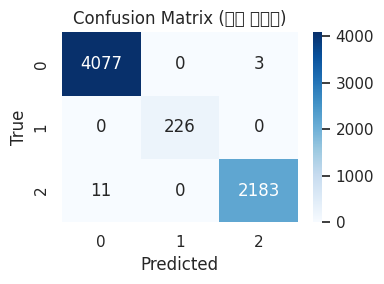

In [14]:
best_model_name = cv_df.loc[0, 'model']
print(f"\nBest Model: {best_model_name} with MAP: {cv_df.loc[0, 'map_mean']:.4f}")

# Final Training on Full Data
print(f"Retraining {best_model_name} on full dataset...")
best_pipeline = pipelines[best_model_name]
best_pipeline.fit(X, y)

y_pred = best_pipeline.predict(X)
y_proba = best_pipeline.predict_proba(X)
train_map = average_precision_score(label_binarize(y, classes=class_labels), y_proba, average='macro')
print(f"Best model: {best_model_name} | Train MAP: {train_map:.3f}")
print(classification_report(y, y_pred, digits=3))
conf_mat = confusion_matrix(y, y_pred)
plt.figure(figsize=(4, 3))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (전체 데이터)')
plt.tight_layout()

# Feature Importance (if applicable)
if hasattr(best_pipeline.named_steps['model'], 'feature_importances_') or best_model_name in ['Stacking_Ensemble', 'Voting_Ensemble', 'Calibrated_Voting', 'Calibrated_LightGBM', 'Blend_LightGBM_XGBoost']:
    print("Calculating permutation importance...")
    perm_result = permutation_importance(best_pipeline, X, y, n_repeats=5, random_state=RANDOM_STATE, scoring=map_macro_score, n_jobs=N_JOBS)
    importance_df = pd.DataFrame({
        'feature': X.columns,
        'importance': perm_result.importances_mean,
        'std': perm_result.importances_std
    }).sort_values('importance', ascending=False).head(15)
    print("\nTop 15 Features:")
    display(importance_df)

In [15]:
# Stacking Ensemble 구성
# XGBoost, CatBoost, HistGradientBoosting, LightGBM 등 고성능 모델 결합
# 튜닝된 모델이 있다면 그것을 사용하고, 없다면 기본 모델 사용
estimators = [
    ('xgb', pipelines.get('XGBoost_Tuned', model_specs['XGBoost']['estimator'])),
    ('cat', pipelines.get('CatBoost_Tuned', model_specs['CatBoost']['estimator'])),
    ('hist', pipelines.get('HistGradientBoosting_Tuned', model_specs['HistGradientBoosting']['estimator'])),
    ('lgbm', pipelines.get('LightGBM_Tuned', model_specs['LightGBM_balanced']['estimator'])),
]

# 파이프라인에서 estimator만 추출 (이미 파이프라인인 경우)
final_estimators = []
for name, est in estimators:
    if isinstance(est, Pipeline):
        final_estimators.append((name, est.named_steps['model']))
    else:
        final_estimators.append((name, est))

# 메타 모델: 로지스틱 회귀
meta_model = LogisticRegression(random_state=RANDOM_STATE)

stacking_clf = StackingClassifier(
    estimators=final_estimators,
    final_estimator=meta_model,
    stack_method='predict_proba', # 분류 문제에서 확률 기반 결합이 유리
    n_jobs=1, # 외부 CV 병렬화와 충돌 방지
    passthrough=False
)

# Stacking 모델 평가
# Stacking은 내부적으로 CV를 수행하므로 시간이 다소 소요됨
stacking_scores = cross_validate(
    make_pipeline(stacking_clf, needs_dense=True),
    X,
    y,
    cv=skf,
    scoring=map_macro_score,
    n_jobs=N_JOBS,
    return_estimator=False
)

stacking_row = pd.DataFrame([
    {
        'model': 'Stacking_Ensemble',
        'map_mean': stacking_scores['test_score'].mean(),
        'map_std': stacking_scores['test_score'].std(),
        'fit_time_s': stacking_scores['fit_time'].mean(),
    }
])

cv_df = (
    pd.concat([stacking_row, cv_df], ignore_index=True)
    .sort_values('map_mean', ascending=False)
    .reset_index(drop=True)
)
pipelines['Stacking_Ensemble'] = make_pipeline(stacking_clf, needs_dense=True)
cv_df

,model,map_mean,map_std,fit_time_s,elapsed_s
0,Blend_LightGBM_XGBoost,0.691,0.015,10.087,NaN
1,Calibrated_LightGBM,0.687,0.018,9.339,NaN
2,LightGBM_Tuned,0.686,0.000,10.801,NaN
3,Calibrated_Voting,0.685,0.015,22.016,NaN
4,XGBoost_Tuned,0.685,0.000,4.008,NaN
5,Voting_Ensemble,0.685,0.015,18.882,NaN
6,RandomForest,0.684,0.019,7.765,7.977
7,RandomForest_Tuned,0.683,0.000,5.996,NaN
8,Stacking_Ensemble,0.682,0.015,336.536,NaN
9,XGBoost,0.682,0.015,4.684,6.116


## 4. 최적 모델 재학습 및 진단
- 최고 MAP을 기록한 파이프라인(튜닝된 HistGBM 포함)을 전체 데이터로 재학습합니다.
- 혼동 행렬과 classification report로 클래스별 성능을 확인합니다.

In [16]:
feature_names = X.columns
perm_result = permutation_importance(
    best_pipeline, X, y, n_repeats=10, random_state=RANDOM_STATE, scoring=map_macro_score
)
importance_df = (pd.DataFrame({
    'feature': feature_names,
    'importance': perm_result.importances_mean,
    'std': perm_result.importances_std
})
 .sort_values('importance', ascending=False)
 .head(15)
 .reset_index(drop=True))
importance_df

,feature,importance,std
0,age_years,0.022,0.003
1,clot_time,0.004,0.000
2,obs_days,0.004,0.001
3,immune_per_behavior,0.002,0.001
4,chem_01,0.002,0.000
5,enzyme_B,0.002,0.000
6,immune_index,0.001,0.000
7,protein_level,0.001,0.000
8,stage_obs_ratio,0.001,0.000
9,blood_cells,0.001,0.000
